In [3]:
import os, time, math, random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, datasets
from torchvision.utils import save_image
from skimage.metrics import peak_signal_noise_ratio as psnr_sk
from skimage.metrics import structural_similarity as ssim_sk

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# This is done just to make sure the model can reporduce the same thing on further reruns

In [5]:
import torch

# Pick GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
base_path = "/kaggle/input/180-dc-ml-sig-recruitment/REC_DATASET"
train_noisy_dir = os.path.join(base_path, "train", "noisy")
train_clean_dir = os.path.join(base_path, "train", "clean")
test_noisy_dir  = os.path.join(base_path, "test", "noisy")
denoised_out_dir = "/kaggle/working/Denoised_Images"
os.makedirs(denoised_out_dir, exist_ok=True)

In [7]:
class FlowerDenoiseDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir=None, augmentations=None):
        self.noisy_paths, self.clean_paths = [], []
        self.augmentations = augmentations

        for class_name in sorted(os.listdir(noisy_dir)):
            ndir = os.path.join(noisy_dir, class_name)
            cdir = os.path.join(clean_dir, class_name) if clean_dir else None
            if not os.path.isdir(ndir):
                continue
            for img_file in sorted(os.listdir(ndir)):
                if img_file.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.noisy_paths.append(os.path.join(ndir, img_file))
                    if cdir:
                        self.clean_paths.append(os.path.join(cdir, img_file))
        if clean_dir is None:
            self.clean_paths = [None] * len(self.noisy_paths)

        # Keep native resolution; ToTensor puts values in [0,1]
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_img = Image.open(self.noisy_paths[idx]).convert("RGB")
        clean_img = None
        if self.clean_paths[idx] and os.path.exists(self.clean_paths[idx]):
            clean_img = Image.open(self.clean_paths[idx]).convert("RGB")

        noisy_img = self.to_tensor(noisy_img)
        if clean_img:
            clean_img = self.to_tensor(clean_img)

        if self.augmentations:
            if clean_img is None:
                pair = torch.stack([noisy_img, noisy_img], dim=0)
            else:
                pair = torch.stack([noisy_img, clean_img], dim=0)
            pair = self.augmentations(pair)
            noisy_img, maybe_clean = pair, pair[11]
            clean_img = maybe_clean if clean_img is not None else None

        return noisy_img, clean_img

full_dataset = FlowerDenoiseDataset(
    train_noisy_dir,
    clean_dir=train_clean_dir,
    augmentations=None
)

val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


**Now we will be going to write the code for the Main Denoiser Model!. I will be using a Autoencoder Supported by a Residual Block**



In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class DenoisingAutoencoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        # Encoder
        self.enc1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.res1 = ResidualBlock(64)
        self.enc2 = nn.Conv2d(64, 128, 3, padding=1)
        self.res2 = ResidualBlock(128)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.enc3 = nn.Conv2d(128, 256, 3, padding=1)
        self.res3 = ResidualBlock(256)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.resd1 = ResidualBlock(128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.resd2 = ResidualBlock(64)
        self.up3 = nn.Conv2d(64, in_channels, 3, padding=1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))
        x1 = self.res1(x1)
        x2 = self.pool(x1)

        x2 = F.relu(self.enc2(x2))
        x2 = self.res2(x2)
        x3 = self.pool(x2)

        x3 = F.relu(self.enc3(x3))
        x3 = self.res3(x3)

        x = F.relu(self.up1(x3))
        x = self.resd1(x + x2)
        x = F.relu(self.up2(x))
        x = self.resd2(x + x1)
        x = self.up3(x)
        x = torch.sigmoid(x)  # [0,1]
        return x

In [9]:
model = DenoisingAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=10,
)

BEST_DENOISER = "/kaggle/working/best_denoiser.pth"
best_val_loss = float("inf")

**The main denoiser model training model loop**

In [12]:
def tensor_to_np01(x):
    x = x.detach().cpu().permute(0, 2, 3, 1).numpy().astype(np.float32)
    return np.clip(x, 0.0, 1.0)

num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        if clean_imgs is None:
            continue
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * noisy_imgs.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    val_psnrs, val_ssims = [], []
    with torch.no_grad():
        for noisy_imgs, clean_imgs in val_loader:
            if clean_imgs is None:
                continue
            noisy_imgs = noisy_imgs.to(device)
            clean_imgs = clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item() * noisy_imgs.size(0)

            ref_np = tensor_to_np01(clean_imgs) 
            den_np = tensor_to_np01(outputs)        

            for r, d in zip(ref_np, den_np):
                val_psnrs.append(psnr_sk(r, d, data_range=1.0))
                val_ssims.append(ssim_sk(r, d, data_range=1.0, channel_axis=-1))

    val_loss /= len(val_loader.dataset)
    val_psnr = float(np.mean(val_psnrs)) if val_psnrs else float("nan")
    val_ssim = float(np.mean(val_ssims)) if val_ssims else float("nan")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
          f"Val PSNR: {val_psnr:.2f} dB | Val SSIM: {val_ssim:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_DENOISER)

    scheduler.step(val_loss)

# Load best denoiser for inference
model.load_state_dict(torch.load(BEST_DENOISER, map_location=device))
model.eval()


Epoch [1/150] Train Loss: 0.005783 | Val Loss: 0.005962 | Val PSNR: 22.44 dB | Val SSIM: 0.6444
Epoch [2/150] Train Loss: 0.006527 | Val Loss: 0.004946 | Val PSNR: 23.31 dB | Val SSIM: 0.6702
Epoch [3/150] Train Loss: 0.006201 | Val Loss: 0.005409 | Val PSNR: 22.91 dB | Val SSIM: 0.6685
Epoch [4/150] Train Loss: 0.005736 | Val Loss: 0.004868 | Val PSNR: 23.41 dB | Val SSIM: 0.6753
Epoch [5/150] Train Loss: 0.005484 | Val Loss: 0.004857 | Val PSNR: 23.40 dB | Val SSIM: 0.6789
Epoch [6/150] Train Loss: 0.005280 | Val Loss: 0.004402 | Val PSNR: 23.86 dB | Val SSIM: 0.6802
Epoch [7/150] Train Loss: 0.005063 | Val Loss: 0.004429 | Val PSNR: 23.85 dB | Val SSIM: 0.6927
Epoch [8/150] Train Loss: 0.005196 | Val Loss: 0.004469 | Val PSNR: 23.82 dB | Val SSIM: 0.6908
Epoch [9/150] Train Loss: 0.005181 | Val Loss: 0.004625 | Val PSNR: 23.64 dB | Val SSIM: 0.6850
Epoch [10/150] Train Loss: 0.005079 | Val Loss: 0.004332 | Val PSNR: 23.95 dB | Val SSIM: 0.6944
Epoch [11/150] Train Loss: 0.004926 | V

DenoisingAutoencoder(
  (enc1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res2): ResidualBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(

**Visualising Some Images from the Validation Model**

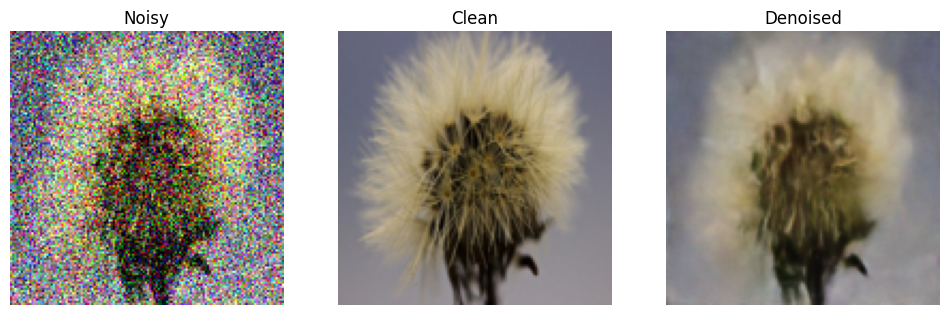

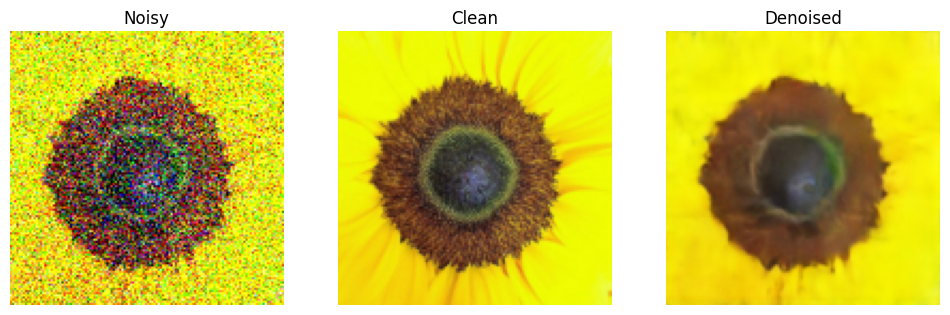

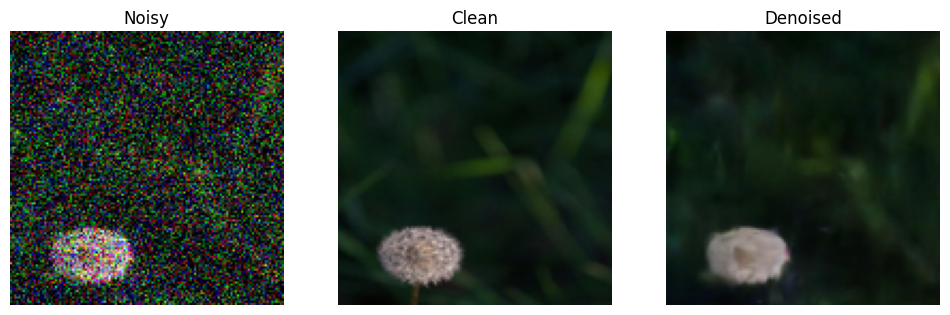

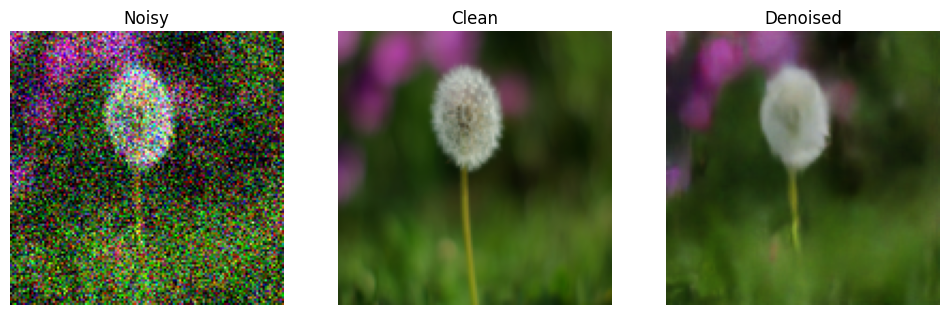

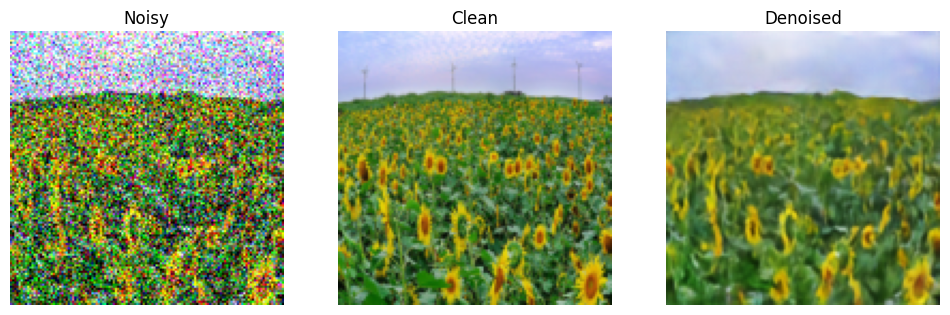

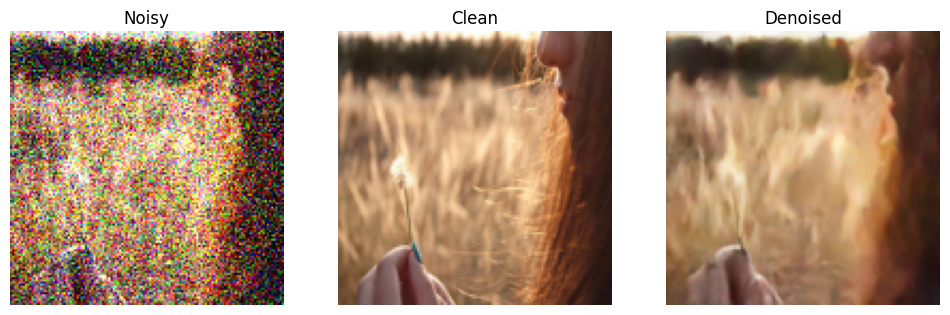

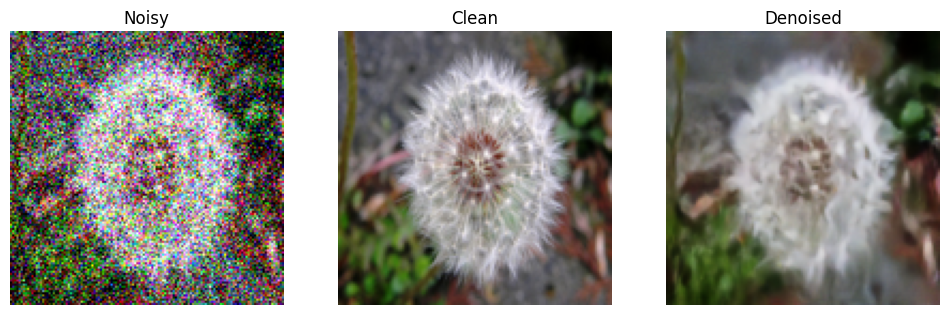

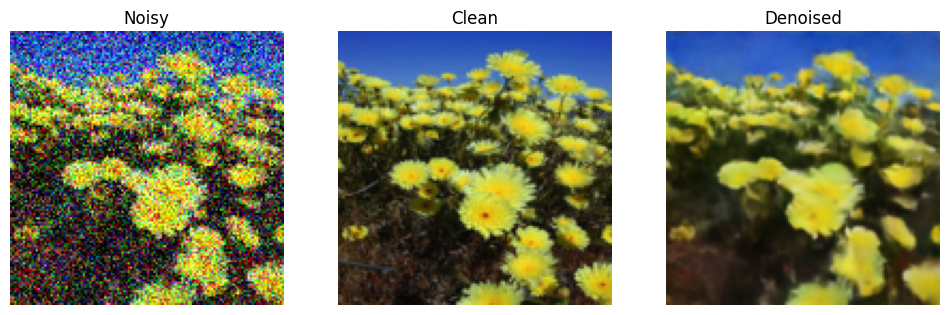

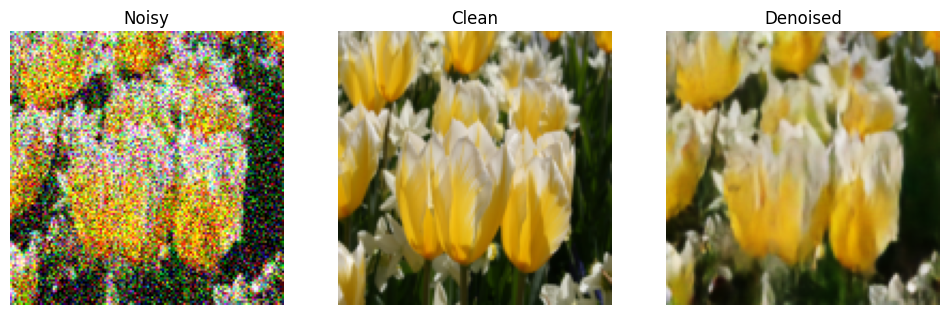

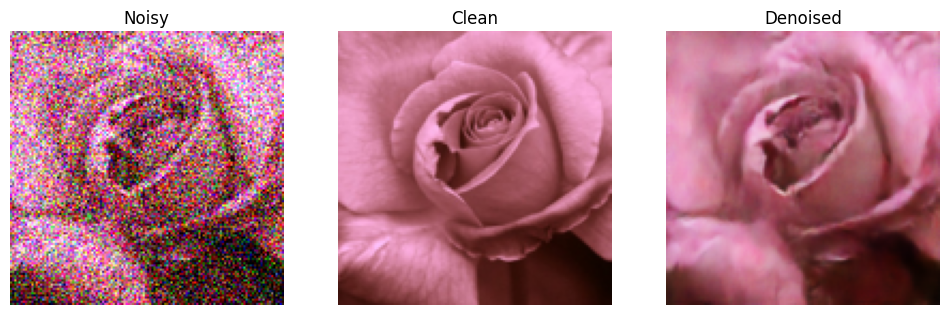

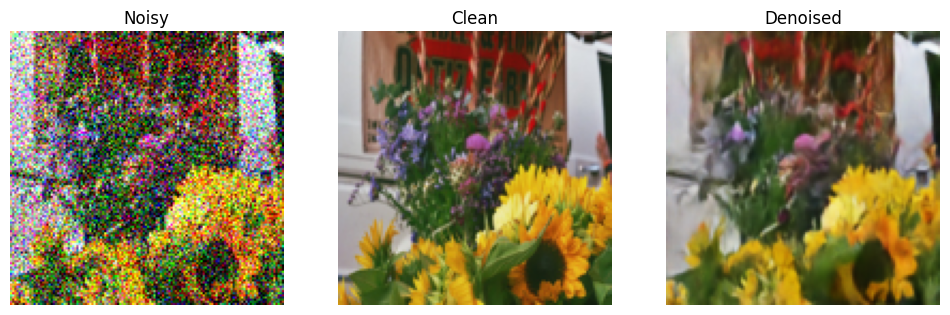

In [13]:
import matplotlib.pyplot as plt
import torch

model.eval()

noisy_imgs, clean_imgs = next(iter(val_loader))
noisy_imgs = noisy_imgs.to(device)
clean_imgs = clean_imgs.to(device)

with torch.no_grad():
    denoised_imgs = model(noisy_imgs)

noisy_imgs = noisy_imgs.cpu()
clean_imgs = clean_imgs.cpu()
denoised_imgs = denoised_imgs.cpu()

def show_images(noisy, clean, denoised, idx=0):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(noisy[idx].permute(1,2,0))
    axes[0].set_title("Noisy")
    axes[0].axis("off")
    
    axes[1].imshow(clean[idx].permute(1,2,0))
    axes[1].set_title("Clean")
    axes[1].axis("off")
    
    axes[2].imshow(denoised[idx].permute(1,2,0))
    axes[2].set_title("Denoised")
    axes[2].axis("off")
    
    plt.show()

for i in range(4):
    show_images(noisy_imgs, clean_imgs, denoised_imgs, idx=i)


In [15]:
class NoisyTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.filenames = sorted([f for f in os.listdir(img_dir)
                                 if f.lower().endswith((".png",".jpg",".jpeg",".bmp"))])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.filenames[idx]

test_transform_denoise = transforms.Compose([
    transforms.Resize((128, 128)),  # <- wrap in tuple
    transforms.ToTensor()
])


test_dataset = NoisyTestDataset(test_noisy_dir, transform=test_transform_denoise)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

with torch.no_grad():
    for noisy_imgs, names in tqdm(test_loader, desc="Denoising TEST"):
        noisy_imgs = noisy_imgs.to(device)
        preds = model(noisy_imgs)
        preds = preds.clamp(0,1).cpu()
        for img_t, fname in zip(preds, names):
            save_image(img_t, os.path.join(denoised_out_dir, fname))

print(f"Denoised test images saved to: {denoised_out_dir}")

Denoising TEST: 100%|██████████| 49/49 [00:09<00:00,  5.20it/s]

Denoised test images saved to: /kaggle/working/Denoised_Images


In [17]:
import shutil, os
denoised_out_dir = "/kaggle/working/Denoised_Images"
zip_path = "/kaggle/working/Denoised_Images.zip"
# base_name without extension, format, root_dir, base_dir
shutil.make_archive(base_name=zip_path.replace(".zip",""),
                    format="zip",
                    root_dir=os.path.dirname(denoised_out_dir),
                    base_dir=os.path.basename(denoised_out_dir))
print("Zipped to:", zip_path)

Zipped to: /kaggle/working/Denoised_Images.zip


**This is done for Downlaoding the Denoised Images as told in github**

In [18]:
from torch.utils.data import ConcatDataset
import pandas as pd

In [19]:
WORK_SIZE = (128, 128)

In [21]:
def load_img01(path, size=WORK_SIZE):
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize(size, Image.BICUBIC)
    return np.asarray(img).astype(np.float32) / 255.0


noisy_files = sorted([f for f in os.listdir(test_noisy_dir) 
                      if f.lower().endswith((".png",".jpg",".jpeg",".bmp"))])

psnr_after, ssim_after = [], []

for fname in tqdm(noisy_files, desc="Computing TEST metrics"):
    noisy_p    = os.path.join(test_noisy_dir, fname)
    denoised_p = os.path.join(denoised_out_dir, fname)
    if not os.path.exists(denoised_p):
        continue
    
    noisy    = load_img01(noisy_p, size=WORK_SIZE)
    denoised = load_img01(denoised_p, size=WORK_SIZE)

    # Compare noisy vs denoised (relative measure only)
    psnr_after.append(psnr_sk(noisy, denoised, data_range=1.0))
    ssim_after.append(ssim_sk(noisy, denoised, data_range=1.0, channel_axis=-1))

print(f"TEST mean PSNR (noisy→denoised): {np.mean(psnr_after):.2f} dB")
print(f"TEST mean SSIM (noisy→denoised): {np.mean(ssim_after):.4f}")


# Save per-image metrics
import pandas as pd
metrics_df = pd.DataFrame({
    "Image": noisy_files[:len(psnr_after)],
    "PSNR_after": psnr_after,
    "SSIM_after": ssim_after
})
metrics_df.to_csv("/kaggle/working/test_metrics.csv", index=False)

Computing TEST metrics: 100%|██████████| 772/772 [00:05<00:00, 145.54it/s]

TEST mean PSNR (noisy→denoised): 13.81 dB
TEST mean SSIM (noisy→denoised): 0.2367


**We didn’t take the “before” PSNR and SSIM because comparing an image with itself always gives PSNR = ∞ and SSIM = 1.0, which carries no useful information about denoising quality.**

Validation PSNR/SSIM are higher because they’re measured against clean ground truth, reflecting true denoising quality.
Test metrics are lower since they compare denoised images to noisy inputs, which only shows difference from noise—not actual image quality.

In [23]:
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

CLS_SIZE = WORK_SIZE  

train_tfms = transforms.Compose([
    transforms.Resize(CLS_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(CLS_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

base_clean = datasets.ImageFolder(train_clean_dir)

num_total = len(base_clean)
val_size = int(0.2 * num_total)
train_size = num_total - val_size
g = torch.Generator().manual_seed(seed)

indices = torch.randperm(num_total, generator=g).tolist()
train_idx = indices[:train_size]
val_idx   = indices[train_size:]

clean_train_ds = datasets.ImageFolder(train_clean_dir, transform=train_tfms)
clean_val_ds   = datasets.ImageFolder(train_clean_dir, transform=val_tfms)

train_cls = Subset(clean_train_ds,train_idx)
val_cls   = Subset(clean_val_ds,val_idx)

train_cls_loader = DataLoader(train_cls, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_cls_loader   = DataLoader(val_cls,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [36]:
class Classifier_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(base_clean.classes)
cls_model = Classifier_CNN(num_classes=num_classes).to(device)

criterion_cls = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_cls = optim.AdamW(cls_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_cls = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cls, mode="min", factor=0.5, patience=10, verbose=True
)
BEST_CLS = "/kaggle/working/best_coralnet.pth"

In [37]:
def train_classifier(model, train_loader, val_loader, epochs=100, patience=10):
    best_acc = 0.0
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs+1):
        # Train
        model.train()
        run_loss, correct = 0.0, 0
        for imgs, labels in tqdm(train_loader, desc=f"[CLS] Epoch {ep}/{epochs} [Train]"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_cls.zero_grad()
            out = model(imgs)
            loss = criterion_cls(out, labels)
            loss.backward()
            optimizer_cls.step()
            run_loss += loss.item() * imgs.size(0)
            pred = out.argmax(1)
            correct += (pred == labels).sum().item()
        tr_loss = run_loss / len(train_loader.dataset)
        tr_acc  = correct / len(train_loader.dataset)

        # Val
        model.eval()
        vloss, correct = 0.0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"[CLS] Epoch {ep}/{epochs} [Val]"):
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                loss = criterion_cls(out, labels)
                vloss += loss.item() * imgs.size(0)
                pred = out.argmax(1)
                correct += (pred == labels).sum().item()
        vloss /= len(val_loader.dataset)
        vacc  = correct / len(val_loader.dataset)

        history["train_loss"].append(tr_loss)
        history["val_loss"].append(vloss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(vacc)

        print(f"Epoch {ep:02d}: train {tr_loss:.4f} | acc {tr_acc:.4f} || val {vloss:.4f} | acc {vacc:.4f}")

        scheduler_cls.step(vloss)
    
        if vacc > best_acc:
            best_acc = vacc
            torch.save(model.state_dict(), BEST_CLS)
            print(f"  → saved best classifier (acc={best_acc:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("⚠️ Early stopping triggered")
            break

    print(f"✅ Training complete. Best val acc = {best_acc:.4f}")
    return history

_ = train_classifier(cls_model, train_cls_loader, val_cls_loader, epochs=100, patience=10)

# Load best classifier
cls_model.load_state_dict(torch.load(BEST_CLS, map_location=device))
cls_model.eval()


[CLS] Epoch 1/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.06it/s]


Epoch 01: train 1.5196 | acc 0.3475 || val 1.3613 | acc 0.4791
  → saved best classifier (acc=0.4791)


[CLS] Epoch 2/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.69it/s]


Epoch 02: train 1.4395 | acc 0.4095 || val 1.3446 | acc 0.4011


[CLS] Epoch 3/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 32.34it/s]


Epoch 03: train 1.4091 | acc 0.4401 || val 1.2960 | acc 0.5181
  → saved best classifier (acc=0.5181)


[CLS] Epoch 4/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 32.71it/s]


Epoch 04: train 1.3793 | acc 0.4749 || val 1.2820 | acc 0.5153


[CLS] Epoch 5/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.66it/s]


Epoch 05: train 1.3435 | acc 0.4875 || val 1.3007 | acc 0.4958


[CLS] Epoch 6/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.06it/s]


Epoch 06: train 1.3275 | acc 0.4916 || val 1.1906 | acc 0.5989
  → saved best classifier (acc=0.5989)


[CLS] Epoch 7/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.41it/s]


Epoch 07: train 1.2988 | acc 0.5286 || val 1.2659 | acc 0.5822


[CLS] Epoch 8/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.22it/s]


Epoch 08: train 1.2957 | acc 0.5286 || val 1.2241 | acc 0.5738


[CLS] Epoch 9/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.41it/s]


Epoch 09: train 1.2783 | acc 0.5474 || val 1.2306 | acc 0.5989


[CLS] Epoch 10/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.33it/s]


Epoch 10: train 1.2549 | acc 0.5494 || val 1.1346 | acc 0.6212
  → saved best classifier (acc=0.6212)


[CLS] Epoch 11/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.17it/s]


Epoch 11: train 1.2685 | acc 0.5655 || val 1.1316 | acc 0.6156


[CLS] Epoch 12/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 32.83it/s]


Epoch 12: train 1.2227 | acc 0.5710 || val 1.1641 | acc 0.5989


[CLS] Epoch 13/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.82it/s]


Epoch 13: train 1.2339 | acc 0.5780 || val 1.3003 | acc 0.5710


[CLS] Epoch 14/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 31.85it/s]


Epoch 14: train 1.2633 | acc 0.5606 || val 1.1109 | acc 0.6407
  → saved best classifier (acc=0.6407)


[CLS] Epoch 15/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 31.65it/s]


Epoch 15: train 1.2063 | acc 0.5996 || val 1.1006 | acc 0.6379


[CLS] Epoch 16/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.02it/s]


Epoch 16: train 1.2021 | acc 0.5843 || val 1.1091 | acc 0.5989


[CLS] Epoch 17/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.81it/s]


Epoch 17: train 1.1951 | acc 0.6024 || val 1.0831 | acc 0.6490
  → saved best classifier (acc=0.6490)


[CLS] Epoch 18/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.72it/s]


Epoch 18: train 1.1912 | acc 0.5933 || val 1.0895 | acc 0.6490


[CLS] Epoch 19/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.23it/s]


Epoch 19: train 1.2245 | acc 0.5627 || val 1.0879 | acc 0.6379


[CLS] Epoch 20/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.09it/s]


Epoch 20: train 1.1787 | acc 0.6142 || val 1.0864 | acc 0.6490


[CLS] Epoch 21/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.33it/s]


Epoch 21: train 1.1628 | acc 0.5996 || val 1.0500 | acc 0.6880
  → saved best classifier (acc=0.6880)


[CLS] Epoch 22/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 37.04it/s]


Epoch 22: train 1.1689 | acc 0.6128 || val 1.1101 | acc 0.6518


[CLS] Epoch 23/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.91it/s]


Epoch 23: train 1.1557 | acc 0.6121 || val 1.0610 | acc 0.6685


[CLS] Epoch 24/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.68it/s]


Epoch 24: train 1.1526 | acc 0.6198 || val 1.0350 | acc 0.6769


[CLS] Epoch 25/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.37it/s]


Epoch 25: train 1.1655 | acc 0.6010 || val 1.0266 | acc 0.6741


[CLS] Epoch 26/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.76it/s]


Epoch 26: train 1.1537 | acc 0.6191 || val 1.1325 | acc 0.6379


[CLS] Epoch 27/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.90it/s]


Epoch 27: train 1.1459 | acc 0.6226 || val 1.0794 | acc 0.6657


[CLS] Epoch 28/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.42it/s]


Epoch 28: train 1.1528 | acc 0.6052 || val 1.0552 | acc 0.6713


[CLS] Epoch 29/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.67it/s]


Epoch 29: train 1.1095 | acc 0.6386 || val 1.0538 | acc 0.6630


[CLS] Epoch 30/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.83it/s]


Epoch 30: train 1.0865 | acc 0.6442 || val 1.0721 | acc 0.6908
  → saved best classifier (acc=0.6908)


[CLS] Epoch 31/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.25it/s]


Epoch 31: train 1.1142 | acc 0.6351 || val 1.0432 | acc 0.6852


[CLS] Epoch 32/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.75it/s]


Epoch 32: train 1.1015 | acc 0.6358 || val 1.0129 | acc 0.6936
  → saved best classifier (acc=0.6936)


[CLS] Epoch 33/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.74it/s]


Epoch 33: train 1.1107 | acc 0.6358 || val 0.9872 | acc 0.6964
  → saved best classifier (acc=0.6964)


[CLS] Epoch 34/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.67it/s]


Epoch 34: train 1.0784 | acc 0.6727 || val 0.9883 | acc 0.6852


[CLS] Epoch 35/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.35it/s]


Epoch 35: train 1.0660 | acc 0.6630 || val 1.0477 | acc 0.6769


[CLS] Epoch 36/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.27it/s]


Epoch 36: train 1.0832 | acc 0.6546 || val 1.0050 | acc 0.7131
  → saved best classifier (acc=0.7131)


[CLS] Epoch 37/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.82it/s]


Epoch 37: train 1.0883 | acc 0.6567 || val 0.9764 | acc 0.7187
  → saved best classifier (acc=0.7187)


[CLS] Epoch 38/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.84it/s]


Epoch 38: train 1.0777 | acc 0.6859 || val 1.0262 | acc 0.6797


[CLS] Epoch 39/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.45it/s]


Epoch 39: train 1.0271 | acc 0.6943 || val 1.0078 | acc 0.7187


[CLS] Epoch 40/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.37it/s]


Epoch 40: train 1.0547 | acc 0.6873 || val 1.0352 | acc 0.6769


[CLS] Epoch 41/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.08it/s]


Epoch 41: train 1.0433 | acc 0.6825 || val 1.0551 | acc 0.6852


[CLS] Epoch 42/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.62it/s]


Epoch 42: train 1.0304 | acc 0.6831 || val 0.9946 | acc 0.6936


[CLS] Epoch 43/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.06it/s]


Epoch 43: train 1.0195 | acc 0.6894 || val 1.0340 | acc 0.7214
  → saved best classifier (acc=0.7214)


[CLS] Epoch 44/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.92it/s]


Epoch 44: train 1.0284 | acc 0.6908 || val 0.9771 | acc 0.7075


[CLS] Epoch 45/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.87it/s]


Epoch 45: train 1.0424 | acc 0.6936 || val 0.9889 | acc 0.7075


[CLS] Epoch 46/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.30it/s]


Epoch 46: train 1.0377 | acc 0.6866 || val 0.9630 | acc 0.7214


[CLS] Epoch 47/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.38it/s]


Epoch 47: train 0.9886 | acc 0.7110 || val 0.9564 | acc 0.7298
  → saved best classifier (acc=0.7298)


[CLS] Epoch 48/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.19it/s]


Epoch 48: train 0.9755 | acc 0.7194 || val 0.9540 | acc 0.7298


[CLS] Epoch 49/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.68it/s]


Epoch 49: train 1.0056 | acc 0.7047 || val 0.9686 | acc 0.7214


[CLS] Epoch 50/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.15it/s]


Epoch 50: train 0.9812 | acc 0.7180 || val 1.0748 | acc 0.7075


[CLS] Epoch 51/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.85it/s]


Epoch 51: train 0.9667 | acc 0.7263 || val 0.9433 | acc 0.7214


[CLS] Epoch 52/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 32.23it/s]


Epoch 52: train 0.9758 | acc 0.7291 || val 1.0498 | acc 0.6964


[CLS] Epoch 53/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.33it/s]


Epoch 53: train 0.9620 | acc 0.7298 || val 0.9768 | acc 0.7409
  → saved best classifier (acc=0.7409)


[CLS] Epoch 54/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.62it/s]


Epoch 54: train 0.9653 | acc 0.7152 || val 1.0064 | acc 0.6908


[CLS] Epoch 55/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.86it/s]


Epoch 55: train 0.9394 | acc 0.7416 || val 0.9140 | acc 0.7688
  → saved best classifier (acc=0.7688)


[CLS] Epoch 56/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.03it/s]


Epoch 56: train 0.9588 | acc 0.7389 || val 0.9003 | acc 0.7660


[CLS] Epoch 57/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.95it/s]


Epoch 57: train 0.9525 | acc 0.7382 || val 0.9247 | acc 0.7354


[CLS] Epoch 58/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.92it/s]


Epoch 58: train 0.9268 | acc 0.7577 || val 0.9674 | acc 0.7549


[CLS] Epoch 59/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.63it/s]


Epoch 59: train 0.9452 | acc 0.7375 || val 0.9518 | acc 0.7382


[CLS] Epoch 60/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.94it/s]


Epoch 60: train 0.9205 | acc 0.7416 || val 0.8931 | acc 0.7827
  → saved best classifier (acc=0.7827)


[CLS] Epoch 61/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.04it/s]


Epoch 61: train 0.9400 | acc 0.7409 || val 0.9108 | acc 0.7437


[CLS] Epoch 62/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.59it/s]


Epoch 62: train 0.9622 | acc 0.7354 || val 0.9646 | acc 0.7103


[CLS] Epoch 63/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.85it/s]


Epoch 63: train 0.8977 | acc 0.7632 || val 1.3018 | acc 0.6100


[CLS] Epoch 64/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.46it/s]


Epoch 64: train 0.9118 | acc 0.7563 || val 0.9131 | acc 0.7549


[CLS] Epoch 65/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.00it/s]


Epoch 65: train 0.9004 | acc 0.7611 || val 0.9819 | acc 0.7159


[CLS] Epoch 66/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.12it/s]


Epoch 66: train 0.8950 | acc 0.7584 || val 0.9020 | acc 0.7409


[CLS] Epoch 67/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.43it/s]


Epoch 67: train 0.8833 | acc 0.7841 || val 0.8702 | acc 0.7911
  → saved best classifier (acc=0.7911)


[CLS] Epoch 68/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.01it/s]


Epoch 68: train 0.8797 | acc 0.7792 || val 0.9129 | acc 0.7549


[CLS] Epoch 69/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.33it/s]


Epoch 69: train 0.8897 | acc 0.7827 || val 0.8927 | acc 0.7827


[CLS] Epoch 70/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.48it/s]


Epoch 70: train 0.8813 | acc 0.7702 || val 0.8400 | acc 0.7939
  → saved best classifier (acc=0.7939)


[CLS] Epoch 71/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.42it/s]


Epoch 71: train 0.8822 | acc 0.7751 || val 0.9688 | acc 0.7131


[CLS] Epoch 72/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.59it/s]


Epoch 72: train 0.8651 | acc 0.7786 || val 0.8902 | acc 0.7827


[CLS] Epoch 73/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.16it/s]


Epoch 73: train 0.8793 | acc 0.7751 || val 0.8462 | acc 0.7939


[CLS] Epoch 74/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.15it/s]


Epoch 74: train 0.8644 | acc 0.7890 || val 0.9734 | acc 0.7549


[CLS] Epoch 75/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.86it/s]


Epoch 75: train 0.8685 | acc 0.7932 || val 0.8808 | acc 0.7772


[CLS] Epoch 76/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.64it/s]


Epoch 76: train 0.8328 | acc 0.8015 || val 0.9268 | acc 0.7577


[CLS] Epoch 77/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.81it/s]


Epoch 77: train 0.8396 | acc 0.7883 || val 0.8893 | acc 0.7660


[CLS] Epoch 78/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.18it/s]


Epoch 78: train 0.8309 | acc 0.8106 || val 0.9440 | acc 0.7465


[CLS] Epoch 79/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.77it/s]


Epoch 79: train 0.8432 | acc 0.7939 || val 0.8284 | acc 0.8106
  → saved best classifier (acc=0.8106)


[CLS] Epoch 80/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.65it/s]


Epoch 80: train 0.8548 | acc 0.7869 || val 0.8011 | acc 0.8273
  → saved best classifier (acc=0.8273)


[CLS] Epoch 81/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.80it/s]


Epoch 81: train 0.8304 | acc 0.7939 || val 0.8337 | acc 0.7939


[CLS] Epoch 82/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.90it/s]


Epoch 82: train 0.8070 | acc 0.8064 || val 0.9216 | acc 0.7382


[CLS] Epoch 83/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.22it/s]


Epoch 83: train 0.8067 | acc 0.8078 || val 0.8354 | acc 0.7911


[CLS] Epoch 84/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.41it/s]


Epoch 84: train 0.8097 | acc 0.8134 || val 0.8123 | acc 0.8134


[CLS] Epoch 85/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 35.22it/s]


Epoch 85: train 0.8060 | acc 0.8057 || val 0.8491 | acc 0.7967


[CLS] Epoch 86/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.85it/s]


Epoch 86: train 0.7913 | acc 0.8210 || val 0.8671 | acc 0.7939


[CLS] Epoch 87/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.97it/s]


Epoch 87: train 0.7708 | acc 0.8343 || val 0.8728 | acc 0.7827


[CLS] Epoch 88/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 36.26it/s]


Epoch 88: train 0.7792 | acc 0.8231 || val 0.8614 | acc 0.7827


[CLS] Epoch 89/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 34.51it/s]


Epoch 89: train 0.8014 | acc 0.8259 || val 0.8619 | acc 0.7883


[CLS] Epoch 90/100 [Val]: 100%|██████████| 23/23 [00:00<00:00, 33.48it/s]

Epoch 90: train 0.7932 | acc 0.8280 || val 0.8897 | acc 0.7799
⚠️ Early stopping triggered
✅ Training complete. Best val acc = 0.8273


Classifier_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

In [38]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.filenames = sorted([f for f in os.listdir(img_dir) if f.lower().endswith((".png",".jpg",".jpeg",".bmp"))])
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self): return len(self.filenames)
    def __getitem__(self, idx):
        p = os.path.join(self.img_dir, self.filenames[idx])
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.filenames[idx]

val_tfms_cls = transforms.Compose([
    transforms.Resize(CLS_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD),
])

test_dataset_cls = TestDataset(denoised_out_dir, transform=val_tfms_cls)
test_loader_cls  = DataLoader(test_dataset_cls, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Mapping required by the challenge
class_to_id = {"daisy":1, "dandelion":2, "roses":3, "sunflowers":4, "tulips":5}
class_names = base_clean.classes  # alphabetical

predictions = []
with torch.no_grad():
    for imgs, names in tqdm(test_loader_cls, desc="Classifying denoised TEST"):
        imgs = imgs.to(device)
        out = cls_model(imgs)
        preds = out.argmax(1).cpu().numpy().tolist()
        for name, p in zip(names, preds):
            cls_name = class_names[p]
            predictions.append((name, class_to_id[cls_name.lower()]))

import pandas as pd
sub = pd.DataFrame(predictions, columns=["Images", "Predicted_Classes"])
sub_path = "/kaggle/working/submission2.csv"
sub.to_csv(sub_path, index=False)
print(f"Kaggle submission saved to {sub_path}")

Classifying denoised TEST: 100%|██████████| 49/49 [00:01<00:00, 40.84it/s]

Kaggle submission saved to /kaggle/working/submission2.csv
